In [2]:
import gym
from gym import spaces
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import time
import math
from IPython.display import display, clear_output

In [3]:
# -----------------------------
# Q-Network for DQN Agent
# -----------------------------
class QNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


# -----------------------------
# Replay Buffer
# -----------------------------
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def size(self):
        return len(self.buffer)


# -----------------------------
# DQN Agent
# -----------------------------
class DQNAgent:
    def __init__(self, action_space, state_space, lr=0.001, gamma=0.99, epsilon=1.0, epsilon_min=0.1, 
                 epsilon_decay=0.995, batch_size=64, buffer_size=10000):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.action_space = action_space  # usually an integer count
        self.state_space = state_space    # dimensionality of flattened state
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size

        self.q_network = QNetwork(state_space, action_space).to(self.device)
        self.target_network = QNetwork(state_space, action_space).to(self.device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.buffer = ReplayBuffer(buffer_size)

        self.update_target_network()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_space)
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        q_values = self.q_network(state)
        return torch.argmax(q_values).item()

    def train(self):
        if self.buffer.size() < self.batch_size:
            return

        batch = self.buffer.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(np.array(states)).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(np.array(next_states)).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)

        # Compute Q values from current network
        q_values = self.q_network(states).gather(1, actions.unsqueeze(1))
        # Compute target Q values from target network
        next_q_values = self.target_network(next_states).max(1)[0].unsqueeze(1)
        target_q_values = rewards.unsqueeze(1) + self.gamma * next_q_values * (1 - dones.unsqueeze(1))

        loss = F.mse_loss(q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [ ]:
# -------------------------------------------
# Collect & Avoid Environment (gym.Env subclass)
# -------------------------------------------

class CollectAvoidEnv(gym.Env):
    def __init__(self, grid_size=15, num_rewards=5, num_enemies=3, enemy_random_move_ratio=0.5):
        super(CollectAvoidEnv, self).__init__()

        self.grid_size = grid_size
        self.num_rewards = num_rewards
        self.num_enemies = num_enemies
        self.enemy_random_move_ratio = enemy_random_move_ratio
        self.reward_positions = []
        self.enemy_positions = []
        self.agent_pos = None

        # Action space: 5 discrete actions
        self.action_space = spaces.Discrete(5)  # 5 actions: stay, up, down, left, right

        # Observation space: grid_size x grid_size grid
        self.observation_space = spaces.Box(low=0, high=3, shape=(grid_size, grid_size), dtype=int)

        # Initialize the plot and axis only once
        self.fig, self.ax = plt.subplots(figsize=(6, 6))
        self.ax.set_xlim(0, self.grid_size - 1)
        self.ax.set_ylim(0, self.grid_size - 1)
        self.ax.set_xticks(range(self.grid_size))
        self.ax.set_yticks(range(self.grid_size))
        self.ax.grid(True)

        self.reset()  # Initialize the environment state

    def reset(self):
        # Initialize positions of rewards, enemies, and agent
        self.reward_positions = [self._random_empty_cell([]) for _ in range(self.num_rewards)]
        self.enemy_positions = [self._random_empty_cell(self.reward_positions) for _ in range(self.num_enemies)]
        self.agent_pos = self._random_empty_cell(self.reward_positions + self.enemy_positions)

        return self._get_state()

    def render(self, episode, step, reward=None):
        # Clear the previous points from the figure, but don't recreate the entire plot
        self.ax.clear()
        self.ax.set_xlim(0, self.grid_size - 1)
        self.ax.set_ylim(0, self.grid_size - 1)
        self.ax.set_xticks(range(self.grid_size))
        self.ax.set_yticks(range(self.grid_size))
        self.ax.grid(True)

        # Plot agent, rewards, and enemies
        self.ax.plot(self.agent_pos[0], self.agent_pos[1], 'bo', markersize=10)  # Agent as blue circle
        for r_pos in self.reward_positions:
            self.ax.plot(r_pos[0], r_pos[1], 'go', markersize=10)  # Reward as green circle
        for e_pos in self.enemy_positions:
            self.ax.plot(e_pos[0], e_pos[1], 'ro', markersize=10)  # Enemy as red circle

        # Display the episode, step, and reward on the plot
        self.ax.text(0.5, self.grid_size - 1, f'Episode: {episode}, Step: {step}', 
                     horizontalalignment='center', verticalalignment='top', fontsize=12, color='black', weight='bold')
        if reward is not None:
            self.ax.text(0.5, self.grid_size - 2, f'Reward: {reward}', 
                         horizontalalignment='center', verticalalignment='top', fontsize=12, color='black', weight='bold')

        # Display the updated plot
        clear_output(wait=True)
        display(self.fig)

        # Pause to update the plot and slow down the environment
        time.sleep(0.1)

    def step(self, action, episode, step):
        # Define the logic for agent movement based on the action taken
        if action == 0:  # stay
            new_pos = self.agent_pos
        elif action == 1:  # up
            new_pos = (max(self.agent_pos[0] - 1, 0), self.agent_pos[1])
        elif action == 2:  # down
            new_pos = (min(self.agent_pos[0] + 1, self.grid_size - 1), self.agent_pos[1])
        elif action == 3:  # left
            new_pos = (self.agent_pos[0], max(self.agent_pos[1] - 1, 0))
        elif action == 4:  # right
            new_pos = (self.agent_pos[0], min(self.agent_pos[1] + 1, self.grid_size - 1))

        self.agent_pos = new_pos

        # Move enemies towards the agent or randomly
        self._move_enemies()

        # Check if the agent collected a reward or encountered an enemy
        reward = 0
        done = False
        if self.agent_pos in self.reward_positions:
            reward = 1  # Reward collected
            self.reward_positions.remove(self.agent_pos)
        if self.agent_pos in self.enemy_positions:
            done = True  # Game over if the agent encounters an enemy

        self.render(episode, step, reward)  # Update the plot with reward, episode, and step
        return self._get_state(), reward, done, {}

    def _move_enemies(self):
        """Move enemies (either move towards agent or randomly)."""
        for i in range(len(self.enemy_positions)):
            x, y = self.enemy_positions[i]

            # Calculate Euclidean distance to the agent
            ax, ay = self.agent_pos
            distance = math.sqrt((ax - x) ** 2 + (ay - y) ** 2)

            if random.random() < (1 -self.enemy_random_move_ratio):  # 50% chance to move towards agent
                # Move towards agent to reduce distance by 50%
                if ax > x:
                    x += 1
                elif ax < x:
                    x -= 1
                if ay > y:
                    y += 1
                elif ay < y:
                    y -= 1
            else:
                # Move randomly in one of the four directions
                direction = random.choice([(0, 1), (1, 0), (0, -1), (-1, 0)])
                x = max(0, min(self.grid_size - 1, x + direction[0]))
                y = max(0, min(self.grid_size - 1, y + direction[1]))

            self.enemy_positions[i] = (x, y)

    def _get_state(self):
        state = np.zeros((self.grid_size, self.grid_size))
        state[self.agent_pos] = 1  # Mark the agent's position
        for r_pos in self.reward_positions:
            state[r_pos] = 2  # Mark rewards
        for e_pos in self.enemy_positions:
            state[e_pos] = 3  # Mark enemies
        return state.flatten()

    def _random_empty_cell(self, excluded_cells):
        """Generate a random empty cell, excluding positions in `excluded_cells`."""
        while True:
            cell = (random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1))
            if cell not in excluded_cells:
                return cell




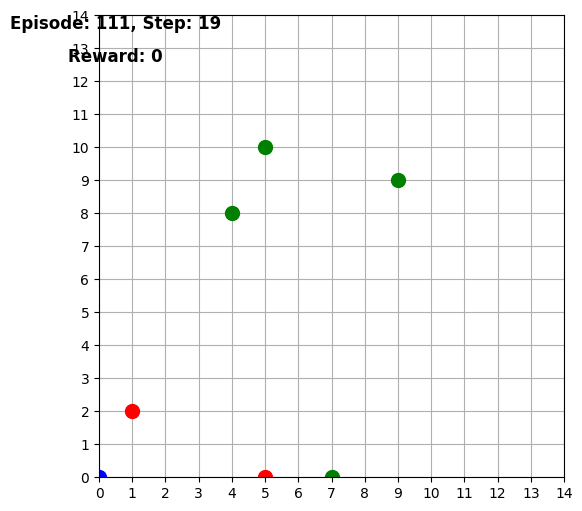

KeyboardInterrupt: 

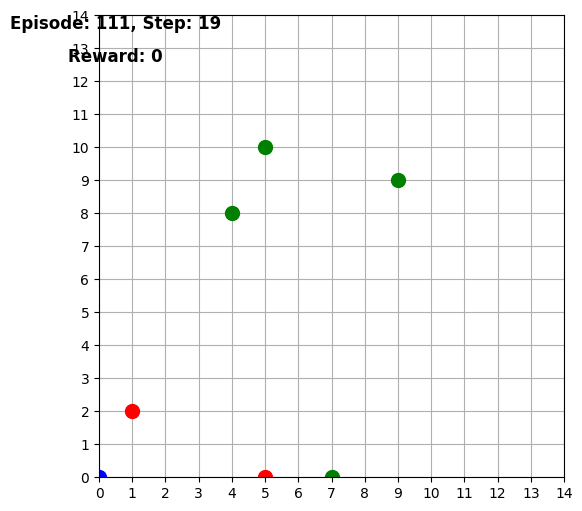

In [ ]:
# -------------------------------------------
# Train the Agent
# -------------------------------------------
env = CollectAvoidEnv(grid_size=15, num_rewards=8, num_enemies=2, enemy_random_move_ratio=0.75)
agent = DQNAgent(env.action_space.n, np.prod(env.observation_space.shape))

episodes = 1000
for episode in range(episodes):
    state = env.reset()
    done = False
    step = 0
    while not done:
        action = agent.act(state)  # Get action from your agent
        next_state, reward, done, _ = env.step(action, episode, step)
        step += 1
        agent.buffer.add((state.flatten(), action, reward, next_state.flatten(), float(done)))
        print(f"E{episode}S{step} | reward: {reward}")
        agent.train()
        if episode > 500:
            time.sleep(0.5)
    if episode % 10 == 0:
        agent.update_target_network()
    print(f"Episode {episode + 1} finished")


env.close()